<a href="https://colab.research.google.com/github/minjeon99/ESAA-10th/blob/Week13/w13_fri_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **07. 군집화**

## **05 DBSCAN**

### **DBSCAN 개요**

밀도 기반 군집화의 대표적인 알고리즘 **DSBCAN(Density Based Spatial Clustering of Applications with Noise)**
- 간단하고 직관적인 알고리즘
- 특정 공간 내 데이터 밀도 차이를 기반 알고리즘으로 하여 복잡한 기하학적 분포도를 가진 데이터 세트에 대해서도 효과적인 군집화 수행
    
    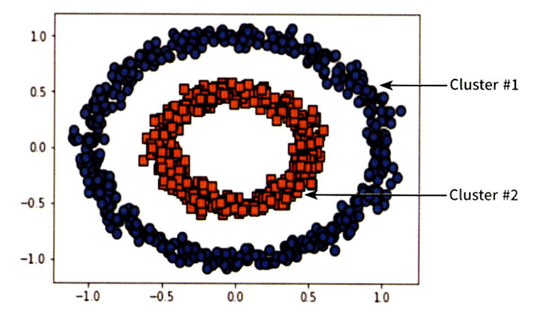
    
    e.g. 내부와 외부의 원 모양 형태의 분포를 가진 데이터 세트 군집화

    : K-평균, 평균 이동, GMM으로는 효과적인 군집화 수행 어려움


**파라미터**
- **입실론 주변 영역(epsilon)**: 개별 데이터를 중심으로 입실론 반경을 가지는 원형의 영역
- **최소 데이터 개수(min points)**: 개별 데이터의 입실론 주변 영역에 포함되는 타 데이터 개수

**데이터 포인트의 구분**
- **핵심 포인트(Core Point)**: 주변 영역 내에 최소 데이터 개수 이상의 타 데이터를 가짐
- **이웃 포인트(Neighbor Point)**: 주변 영역 내에 위치
- **경계 포인트(Border Point)**: 주변 영역 내에 최소 데이터 개수 이상의 이웃 포인트를 가지고 있지 않지만 핵심 포인트를 이웃 포인트로 가짐
- **잡음 포인트(Noise Point)**: 최소 데이터 개수 이상의 이웃 포인트를 가지고 있지 않으며, 핵심 포인트도 이웃 포인트로 가지고 있지 않음

**군집화 적용 예시 및 주요 개념 설명**
1. P1~P12, 특정 입실론 반경 내에 포함될 최소 데이터 세트를 6개로 가정 (자신 포함)
2. P1 기준, 입실론 반경 내 포함된 데이터: 7개 (최소 데이터 5개 이상 만족) => P1은 핵심 포인트

  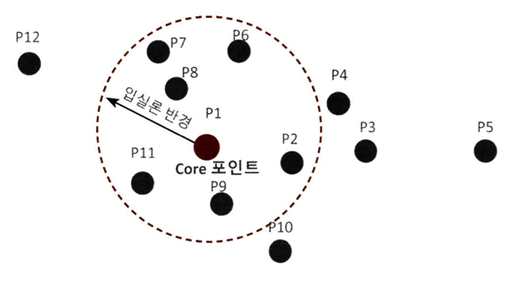
3. P2: 반경 내에 6개의 데이터 가짐 => 핵심 포인트

  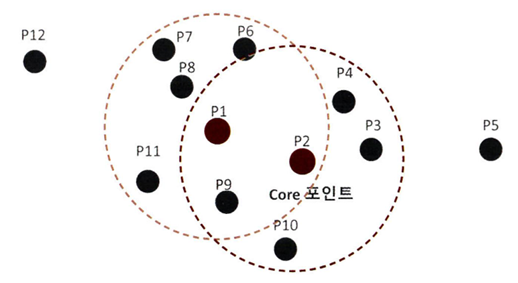
4. 핵심 포인트 P1의 이웃 데이터 포인트 P2 역시 핵심 푕ㄴ트인 경우 P1에서 P2로 연결해 직적 접근 가능

  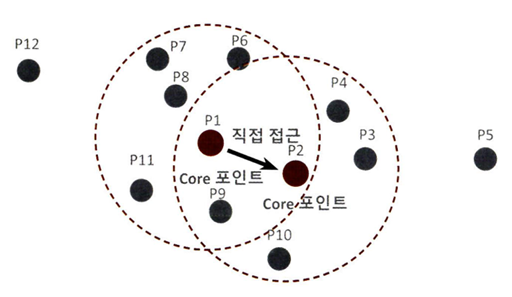
5. 특정 핵심 포인트에서 직접 접근이 가능한 다른 핵심 포인트들을 서로 연결하면서 군집화 구성

  => 점차적으로 군집(Cluster) 영역을 확장해 나가는 것이 DBSCAN 군집화 방식

  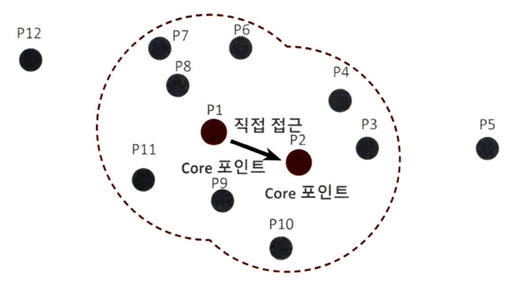
6. P3: 반경 내에 포함되는 이웃데이터 2개 => 핵심 포인트 X
  - 이웃 데이터 중 핵심 포인트인 P2를 가짐 => 경계 포인트
  - 경계 포인트는 군집의 외곽을 형성

  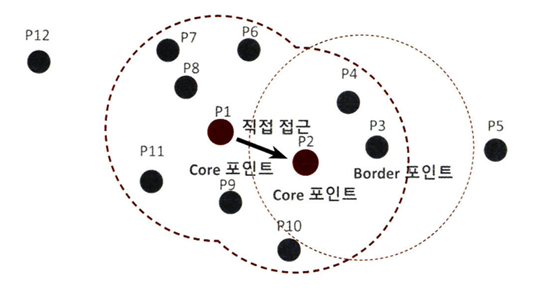
7. P5는 반경 내에 최소 데이터 가지지 X, 핵심 포인트를 이웃데이터로 가지고 있지도 X => 잡음 포인트

  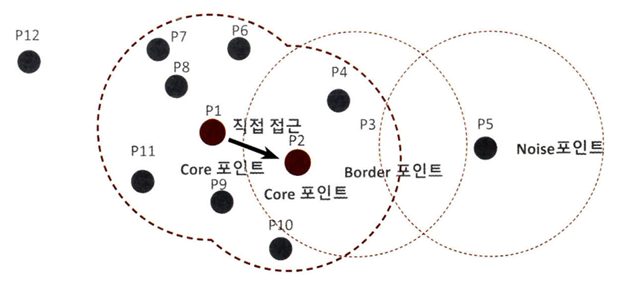

**사이킷런의 `DBSCAN` 클래스**
- 초기화 파라미터
  - `eps`: 입실론 주변 영역의 반경
  - `min_samples`: 핵심 포인트가 되기 위해 입실론 주변 영역에 포함돼야 할 데이터의 최소 개수
    
    (자신의 데이터 포함 => 위에서 설명한 *min point+1*)

### **DBSCAN 적용하기 - 붓꽃 데이터 세트**

일반적으로 eps 값은 1 이하의 값 설정

In [27]:
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# 보다 편리한 데이타 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [28]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: count, dtype: int64


- 군집 레이블=-1: 노이즈에 속하는 군집
- 2개의 군집으로 군집화

  Target 유형이 3가지인데, 군집이 2개가 됐다고 군집화 효율이 떨어진다는 의미는 아님
- DBSCAN은 군집의 개수를 알고리즘에 따라 자동 지정하므로 군집의 개수를 지정하는 것은 무의미
  - 붓꽃 데이터 세트는 군집을 3개보다 2개로 하는 것이 군집화 효율로서 더 좋은 면이 있음

**2차원 평면에서 시각화**
- 2개의 피처로 압축 변환
- 시각화

In [29]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_

    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)

        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)

        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'

    plt.legend(loc=legend_loc)
    plt.show()

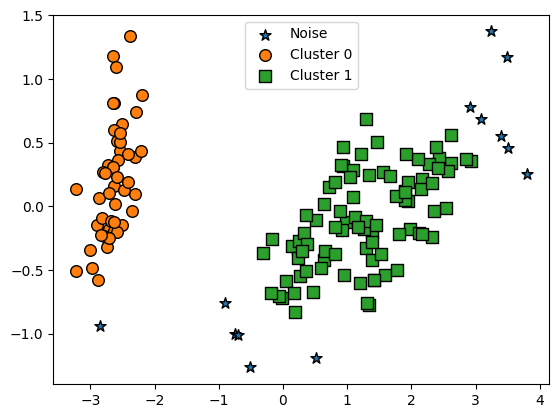

In [30]:
from sklearn.decomposition import PCA
# 2차원으로 시각화하기 위해 PCA n_componets=2로 피처 데이터 세트 변환
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(iris.data)
# visualize_cluster_2d( ) 함수는 ftr1, ftr2 컬럼을 좌표에 표현하므로 PCA 변환값을 해당 컬럼으로 생성
irisDF['ftr1'] = pca_transformed[:,0]
irisDF['ftr2'] = pca_transformed[:,1]

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

- 별표로 표현된 값=노이즈
- DBSCAN 적용할 때는 특정 군집 개수로 군집 강제하지 않는 것이 좋음
  - `eps`, `min_samples` 파라미터를 통해 최적의 군집을 찾는 게 중요
  - **eps**: 크게 하면 반경이 커져 포함하는 데이터가 많아지므로 노이즈 데이터 개수가 작아짐
  - **min_samples**: 크게 하면 주어진 반경 내에서 더 많은 데이터를 포함시켜야 하므로 노이즈 데이터 개수가 커짐
    - 매우 촘촘한 데이터 분포가 아닌 경우 노이즈로 인식하기 때문

**eps 변화에 따른 노이즈 데이터 수**

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: count, dtype: int64


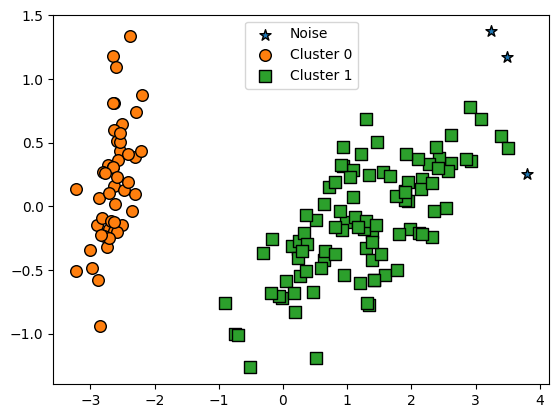

In [31]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

- 노이즈인 군집이 3개밖에 없음

target  dbscan_cluster
0        0                48
        -1                 2
1        1                44
        -1                 6
2        1                36
        -1                14
Name: count, dtype: int64


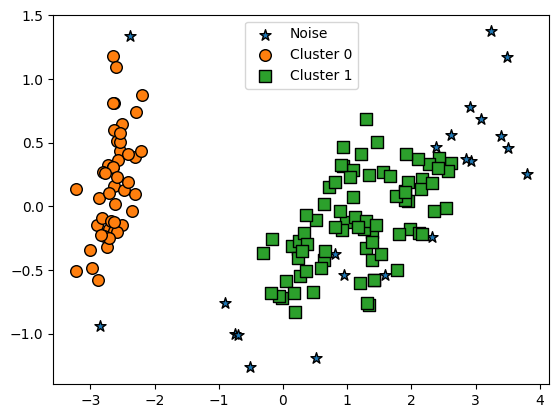

In [35]:
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

- 노이즈 데이터가 증가함

### **DBSCAN 적용하기 - make_circles() 데이터 세트**

복잡한 기하학적 분포를 가지는 데이터 세트에서 DBSCAN과 타 알고리즘 비교
- `make_circles()`를 이용해 내부 원과 외부 원 형태로 돼 있는 2차원 데이터 세트 만들기
  - 항상 2개의 피처만을 생성 => 별도의 피처 개수 지정할 필요 X
  - `noise`: 노이즈 데이터 세트의 비율
  - `factor`: 외부 원과 내부 원의 scale 비율

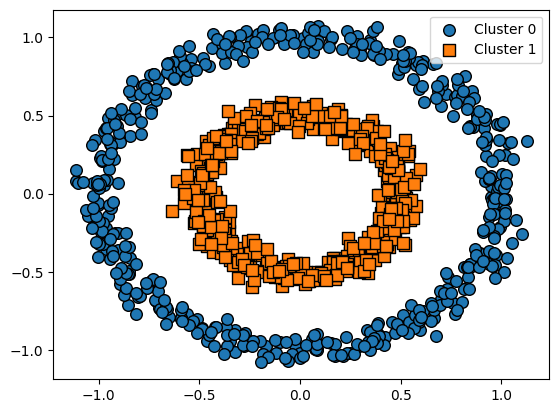

In [37]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=0, factor=0.5)
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

**K-평균, GMM**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


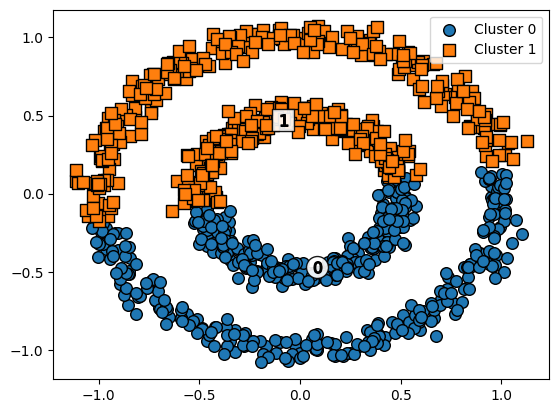

In [40]:
# Kmeans로 make_circles() 데이터 세트 군집화
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels = kmeans.fit_predict(X)
clusterDF['kmeans_cluster'] = kmeans_labels

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=True)

- 위, 아래 군집 중심을 기반으로 위와 아래 절반으로 군집화

  => 거리 기반 군집화로는 데이터가 특정한 형태로 지속해서 이어지는 부분을 찾기 어려움

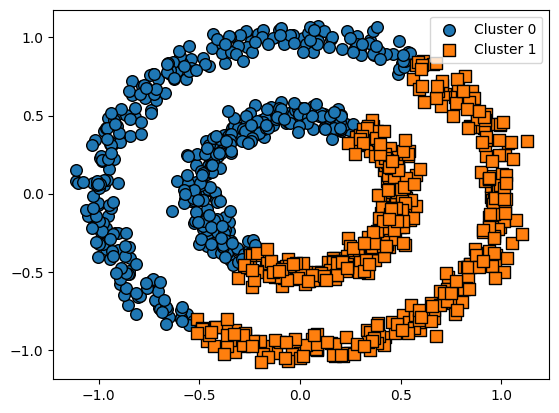

In [41]:
# GMM으로 make_circles() 데이터 세트를 군집화 수행
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=0)
gmm_label = gmm.fit(X).predict(X)
clusterDF['gmm_cluster'] = gmm_label

visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)

- gmm도 일렬로 늘어선 데이터 세트에서는 효과적으로 군집화 적용이 가능했으나,

  내부와 외부 원형의 더 복잡한 형태는 군집화가 원하는 방향으로 되지 않음

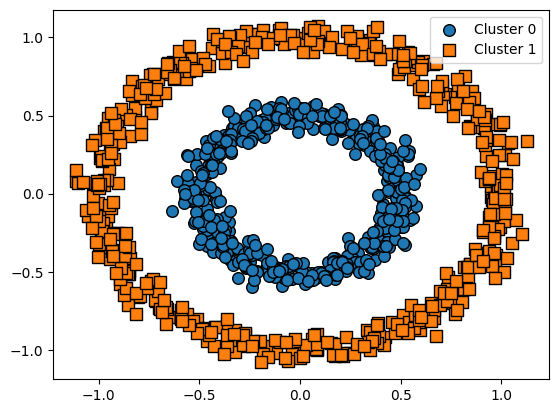

In [43]:
# DBSCAN으로 make_citcles() 데이터 세트 군집화 수행
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_cluster'] = dbscan_labels
visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)

- 원하는 방향으로 정확히 군집화 수행